In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
sns.set_style("darkgrid")
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Dropout, concatenate
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, mean_squared_error,  mean_absolute_error, jaccard_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import zscore
from scipy import stats

In [4]:
#Loading the dataset
dataset = pd.read_csv('BATADAL_refined.csv')
dataset = dataset.dropna()

In [5]:
# Exclude rows where LABEL is -999
dataset = dataset[dataset['ATT_FLAG'] != -999]

In [6]:
class_counts = dataset['ATT_FLAG'].value_counts()

print(class_counts)

0    8761
1     219
Name: ATT_FLAG, dtype: int64


In [7]:
# extract the features and target variable
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [8]:
# preprocess the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# split the dataset into training, testing, and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
dataset.head()

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,99.018150,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,99.115639,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,98.440498,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,97.594460,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,97.370277,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


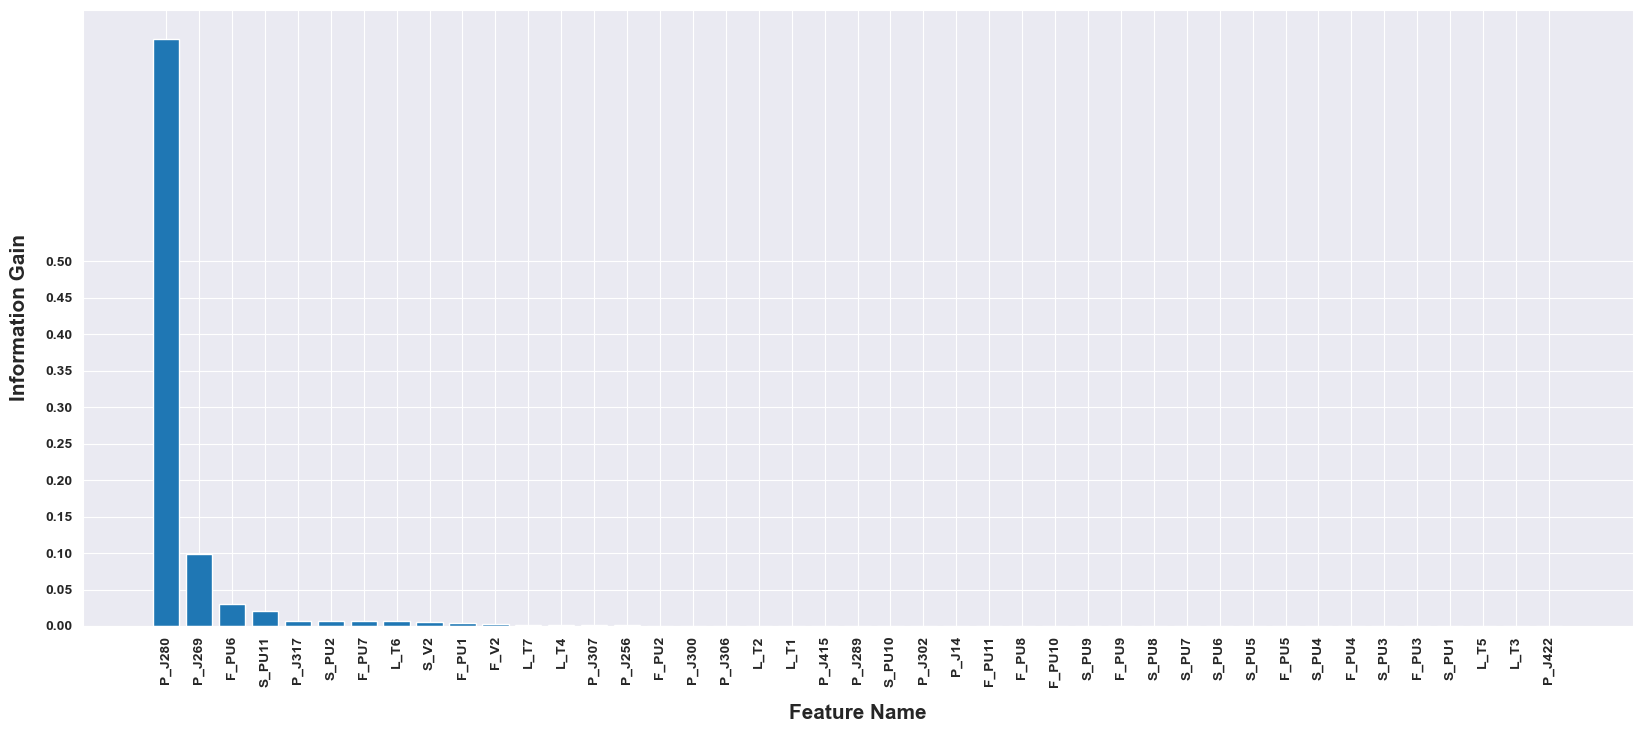

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train, y_train, X_val, X_test, and dataset are already defined

# Apply Information Gain for feature selection
# Convert X_train to DataFrame for feature names
X_train_df = pd.DataFrame(X_train, columns=dataset.columns[:-1])

# Fit a DecisionTreeClassifier to compute feature importances (Information Gain)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances (Information Gain)
importances = clf.feature_importances_

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({
    'Feature': dataset.columns[:-1],
    'Importance': importances
})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 8))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xticks(rotation=90, weight="bold")

# Setting y-axis ticks from 0.00 to 0.50 with intervals of 0.05
plt.yticks(np.arange(0.00, 0.55, 0.05), weight="bold")  
plt.xlabel("Feature Name", weight="bold", labelpad=12, fontsize=15)
plt.ylabel("Information Gain", weight="bold", labelpad=12, fontsize=15)
plt.show()

# Select top features based on Information Gain
top_features = importances_df['Feature'][:2]  # Select top 4 features

# Use the top features for further processing
X_train_selected = X_train_df[top_features]
X_test_selected = pd.DataFrame(X_test, columns=dataset.columns[:-1])[top_features]
X_val_selected = pd.DataFrame(X_val, columns=dataset.columns[:-1])[top_features]

# Apply SparsePCA for feature reduction
spca = SparsePCA(n_components=2)
X_train = spca.fit_transform(X_train_selected)
X_val = spca.transform(X_val_selected)
X_test = spca.transform(X_test_selected)

# Reshape the data for the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
# Add attention mechanism after the second LSTM layer
model.add(AttentionLayer())

# Reshape the output of the Attention layer to add the missing timestep dimension
model.add(tf.keras.layers.Reshape((1, -1)))

model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])



In [14]:
#Define a learning rate schedular
def scheduler(epoch, lr):
    if epoch <=10:
        return lr #Keep the initial learning rate for the first 200 epochs
    else:
        return lr * tf.math.exp(-0.1) # Reduce the learning rate by a factor of 0.1 after the 200th epoch

In [15]:
lr=0.001
for i in range (100):
    lr=scheduler(i,lr)
    print(i,lr)


0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 tf.Tensor(0.00090483745, shape=(), dtype=float32)
12 tf.Tensor(0.0008187308, shape=(), dtype=float32)
13 tf.Tensor(0.0007408183, shape=(), dtype=float32)
14 tf.Tensor(0.0006703201, shape=(), dtype=float32)
15 tf.Tensor(0.00060653075, shape=(), dtype=float32)
16 tf.Tensor(0.00054881175, shape=(), dtype=float32)
17 tf.Tensor(0.0004965854, shape=(), dtype=float32)
18 tf.Tensor(0.00044932903, shape=(), dtype=float32)
19 tf.Tensor(0.0004065697, shape=(), dtype=float32)
20 tf.Tensor(0.0003678795, shape=(), dtype=float32)
21 tf.Tensor(0.00033287113, shape=(), dtype=float32)
22 tf.Tensor(0.00030119426, shape=(), dtype=float32)
23 tf.Tensor(0.00027253185, shape=(), dtype=float32)
24 tf.Tensor(0.00024659702, shape=(), dtype=float32)
25 tf.Tensor(0.0002231302, shape=(), dtype=float32)
26 tf.Tensor(0.00020189656, shape=(), dtype=float32)
27 tf.Tensor(0.00018268357, shape=(), dtype=float32)
28 tf.Tensor(0.00

In [16]:
callback=LearningRateScheduler(scheduler)

In [17]:
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/100


176/176 [==============================] - 4s 7ms/step - loss: 0.1687 - accuracy: 0.7410 - val_loss: 0.0914 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 2/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0936 - accuracy: 0.8555 - val_loss: 0.0771 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 3/100
176/176 [==============================] - 1s 6ms/step - loss: 0.0865 - accuracy: 0.8690 - val_loss: 0.0749 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 4/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0837 - accuracy: 0.8723 - val_loss: 0.0730 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 5/100
176/176 [==============================] - 1s 6ms/step - loss: 0.0830 - accuracy: 0.8737 - val_loss: 0.0715 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.8761 - val_loss: 0.0706 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 7/100
176/176 [==============================] - 1s 5ms/

In [18]:
_,acc = model.evaluate(X_test, y_test)
print("Accuracy =", (acc * 100.0), "%")
_,pre = model.evaluate(X_test, y_test)
print("Precision =", (pre * 100.0), "%")
_,f1score = model.evaluate(X_test, y_test)
print("F1 Score =", (f1score * 100.0), "%")
_,rec = model.evaluate(X_test, y_test)
print("Recall =", (rec * 100.0), "%")
_,score = model.evaluate(X_test, y_test)
print('Test score:', (score * 100.0), "%")

110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Accuracy = 90.7560646533966 %
110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Precision = 90.7560646533966 %
110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
F1 Score = 90.7560646533966 %
110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Recall = 90.7560646533966 %
110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Test score: 90.7560646533966 %


110/110 [==============================] - 1s 2ms/step
Precision: 0.9076
Recall: 0.9076
Accuracy: 0.9076
F1 Score: 0.8980
Jaccard Score: 0.8150
Log Loss: 3.3319
Confusion Matrix:
[[1754    1]
 [ 323 1427]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1755
           1       1.00      0.82      0.90      1750

    accuracy                           0.91      3505
   macro avg       0.92      0.91      0.91      3505
weighted avg       0.92      0.91      0.91      3505

ROC AUC Score:
0.9074293854293854


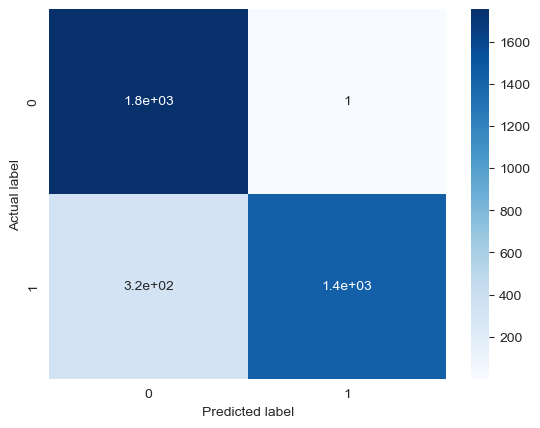

In [19]:
# Evaluate the model
#y_pred = model.predict(X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1)))
#y_pred = model.predict_classes(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#print("Confusion Matrix:")
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

110/110 [==============================] - 0s 2ms/step


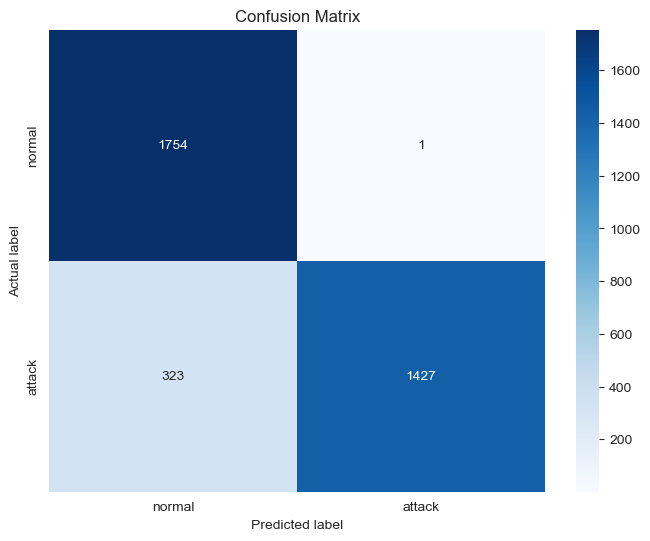

Precision: 0.9076
Recall: 0.9076
Accuracy: 0.9076
F1 Score: 0.8980
Jaccard Score: 0.8150
Log Loss: 3.3319

Confusion Matrix:
[[1754    1]
 [ 323 1427]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1755
           1       1.00      0.82      0.90      1750

    accuracy                           0.91      3505
   macro avg       0.92      0.91      0.91      3505
weighted avg       0.92      0.91      0.91      3505


ROC AUC Score:
0.9074293854293854


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, jaccard_score, log_loss, classification_report, roc_auc_score

# Example: Assuming y_test and y_pred are defined
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['normal', 'attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print evaluation metrics
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

In [21]:
# Calculate Z-score
training_error = history.history['loss'][-1]
testing_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]
z_score = (training_error - validation_error) / np.std(history.history['val_loss'])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score:", z_score)


Mean Squared Error: 0.09243937232524964
Training Error: 0.06224434822797775
Validation Error: 0.05412627011537552
Z-Score: 1.373524355399235


In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute predictions for the test dataset
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5)  # Convert predictions to binary

# Calculate Mean Squared Error for the test dataset
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate training and validation errors from history
training_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]

# Calculate the mean and standard deviation of training and validation errors
val_loss_std = np.std(history.history['val_loss'])
train_loss_mean = np.mean(history.history['loss'])

# Calculate Z-score for the test error
# Note: This is a relative measure, using training error and validation loss as benchmarks
z_score = (test_mse - train_loss_mean) / val_loss_std

# Print results
print("Test Mean Squared Error:", test_mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score (test error):", z_score)

110/110 [==============================] - 0s 2ms/step
Test Mean Squared Error: 0.09243937232524964
Training Error: 0.06224434822797775
Validation Error: 0.05412627011537552
Z-Score (test error): 4.429844649103903


AUC: 0.9074293854293854


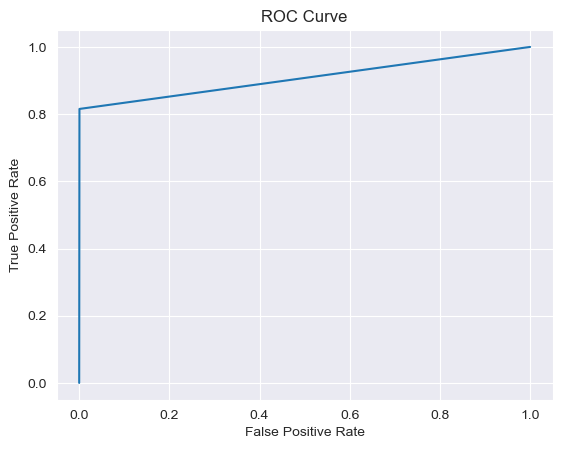

In [23]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plot.bar(figsize=(20,8))
print("AUC:", roc_auc)


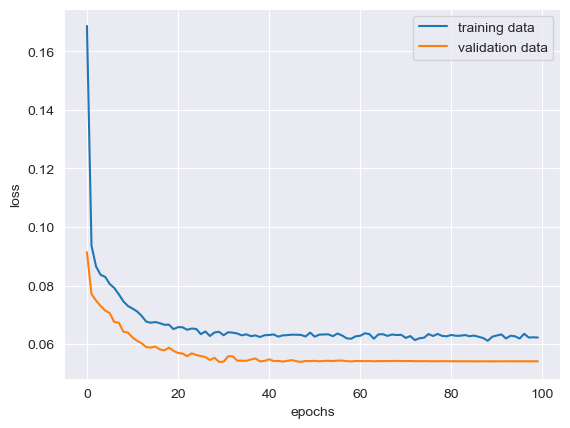

In [24]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

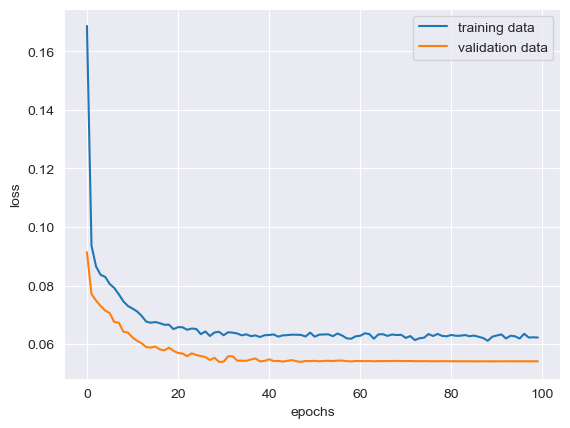

In [25]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

In [26]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'epochs' is not defined

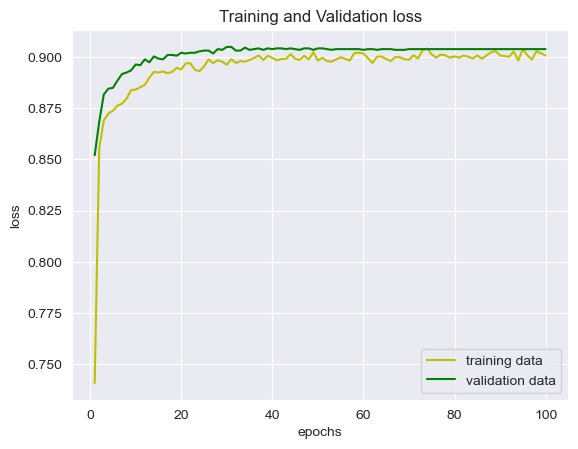

In [27]:
loss= history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, acc,'y', label='training data')
plt.plot(epochs,val_acc,'g', label='validation data')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

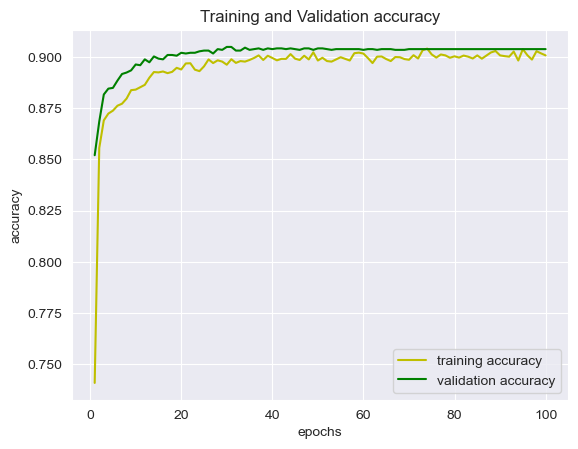

In [28]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [29]:

# Predict probabilities for both models
pred = model.predict(X_test)


110/110 [==============================] - 0s 3ms/step


In [30]:
# Compute ROC curve and area under curve (AUC) for both models
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = auc(fpr, tpr)

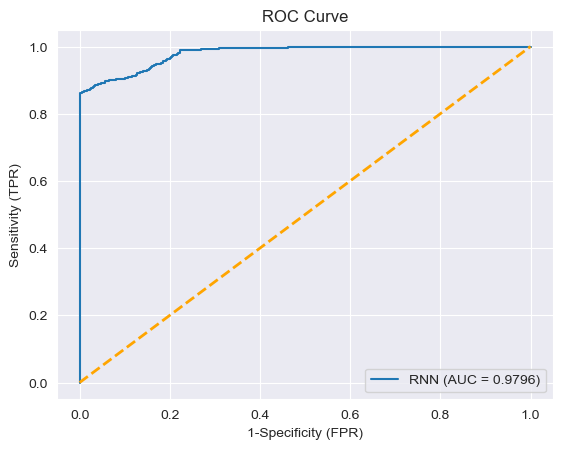

In [31]:
plt.plot(fpr, tpr, label='RNN (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

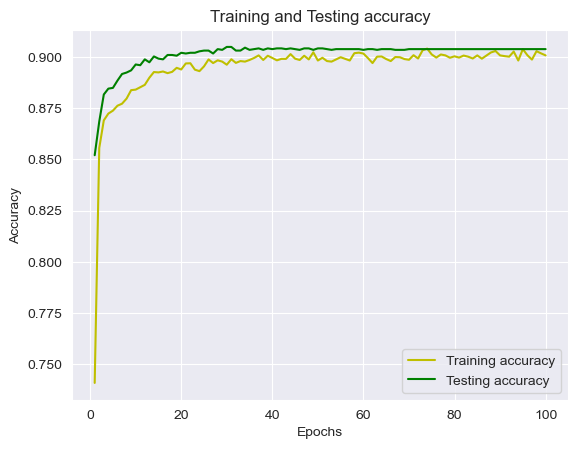

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']  # Training accuracy
test_acc = history.history['val_accuracy']  # Testing accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, test_acc, 'g', label='Testing accuracy')

plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Final Training Loss: 0.06224434822797775
Testing Loss: 0.055127423256635666


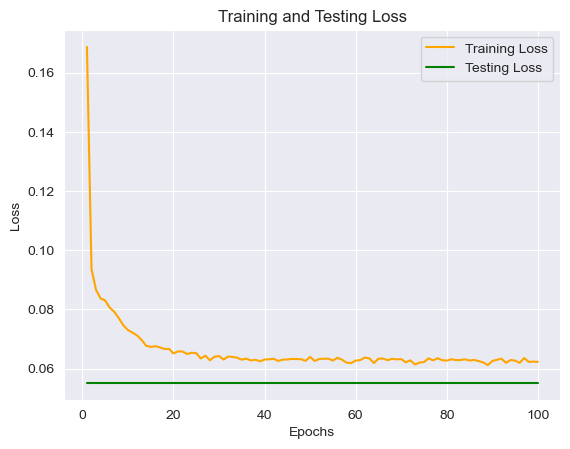

In [33]:
import matplotlib.pyplot as plt

# Extract training loss from history
train_loss = history.history['loss']

# Evaluate the model on the test data to get the testing loss
test_loss, _ = model.evaluate(X_test, y_test)

# Print training and testing loss
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Testing Loss: {test_loss}")

# Create an array of epochs for plotting
epochs = range(1, len(train_loss) + 1)

# Plot training loss
plt.plot(epochs, train_loss, 'orange', label='Training Loss')

# Plot testing loss
plt.plot(epochs, [test_loss] * len(epochs), 'green', label='Testing Loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

110/110 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9076
Final Training Accuracy: 0.9006510376930237
Testing Accuracy: [0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.9075606465339661, 0.907560

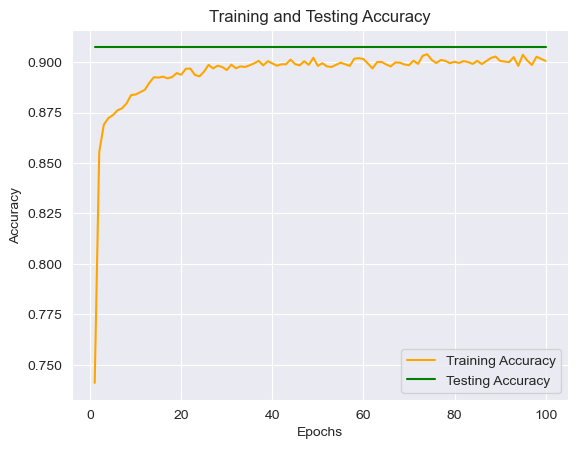

In [34]:
import matplotlib.pyplot as plt

# Example data (replace with actual data)
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
test_acc = [test_acc] * len(epochs)  # Incorrect definition, causing the error

# Assuming test_acc is a scalar for the entire test set accuracy
# Evaluate the model on the test data to get the testing accuracy
_, test_acc = model.evaluate(X_test, y_test)

# Correct test_acc to be a list with the same value across all epochs
test_acc = [test_acc] * len(epochs)

# Print training and testing accuracy
print(f"Final Training Accuracy: {train_acc[-1]}")
print(f"Testing Accuracy: {test_acc}")

# Plot training accuracy
plt.plot(epochs, train_acc, 'orange', label='Training Accuracy')

# Plot testing accuracy
plt.plot(epochs, test_acc, 'green', label='Testing Accuracy')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
